In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# from warnings import filterwarnings
# filterwarnings(action='ignore')

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [3]:
input_location = 'KTH-io-aware'
files_prefix = ''
schedule_names = ['filler', 'backfill-1', 'no-reserve-1', 'fcfs']

In [4]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware/backfill-1_schedule.csv', '../output/KTH-io-aware/balance-09-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-10-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-11-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-12-ratio-1_schedule.csv', '../output/KTH-io-aware/fcfs_schedule.csv', '../output/KTH-io-aware/filler_schedule.csv', '../output/KTH-io-aware/no-reserve-1_schedule.csv']
['../output/KTH-io-aware/backfill-1_jobs.csv', '../output/KTH-io-aware/balance-09-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-10-largest-1_jobs.csv', '../output/KTH-io-aware/balance-10-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-11-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-12-ratio-1_jobs.csv', '../output/KTH-io-aware/fcfs_jobs.csv', '../output/KTH-io-aware/filler_jobs.csv', '../output/KTH-io-aware/no-reserve-1_jobs.csv']


In [5]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule')

 backfill-1
 fcfs
 filler
 no-reserve-1


In [6]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 fcfs
 filler
 no-reserve-1


In [7]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    # If job timeout in the stage-in phase then allocated_resources and proc_alloc will be NaN
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    static_jobs.reset_index(inplace=True)
    return static_jobs

In [8]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [9]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [10]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [15]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
sns.set_theme(context='talk', style='whitegrid')
# sns.set_theme(style='whitegrid')

In [16]:
metrics.T

,filler,backfill-1,no-reserve-1,fcfs
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0
makespan,2.88581e+07,2.88019e+07,4.14554e+07,3.78922e+07
max_slowdown,1.00023,1.00024,1.00024,1.00023
max_turnaround_time,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06
mean_slowdown,0.975925,0.975917,0.975923,0.975918
mean_turnaround_time,223.303,223.766,223.047,224.723
mean_waiting_time,0,0,0,0
nb_computing_machines,109,109,109,109


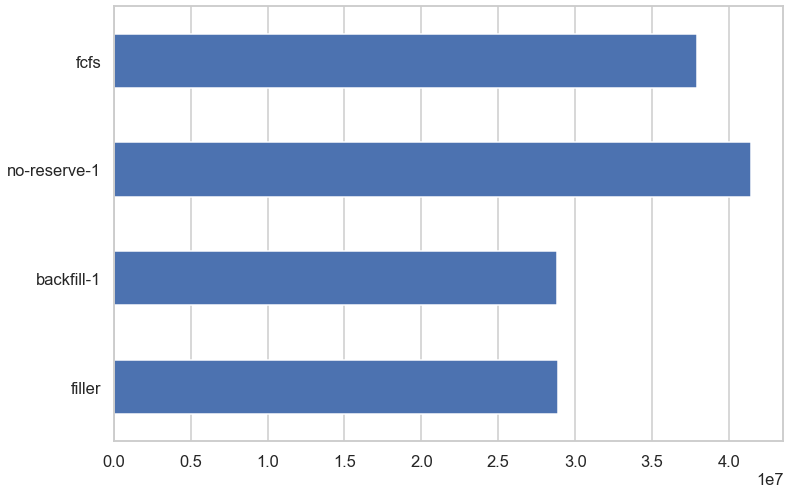

In [17]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

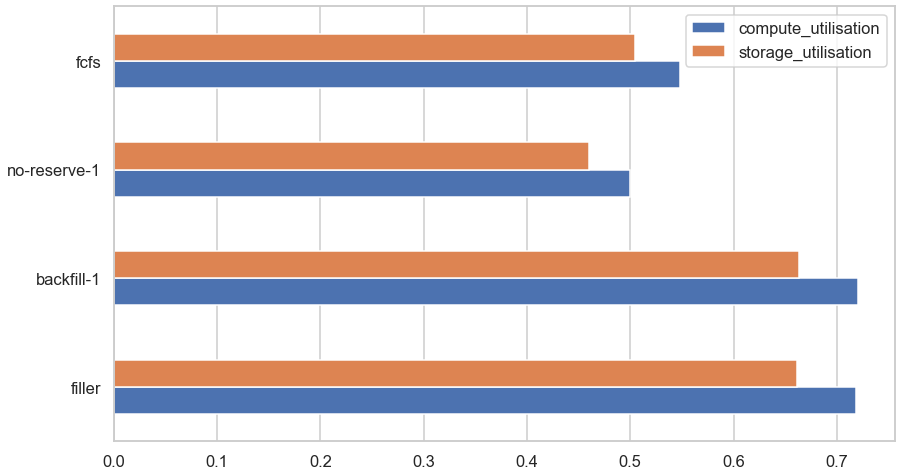

In [55]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [56]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,2.125873e+04,14554.136424,1.365421e+06,5.624141e+06
std,1.508317e+05,40463.245257,4.083889e+06,2.597422e+06
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000,8.929770e+03,3.441304e+06
50%,0.000000e+00,82.648256,5.513503e+04,6.212772e+06
75%,5.005819e+03,9469.730070,4.403723e+05,7.736881e+06
max,4.991701e+06,639435.911771,2.827272e+07,9.207424e+06


(0.0, 29686355.755517997)

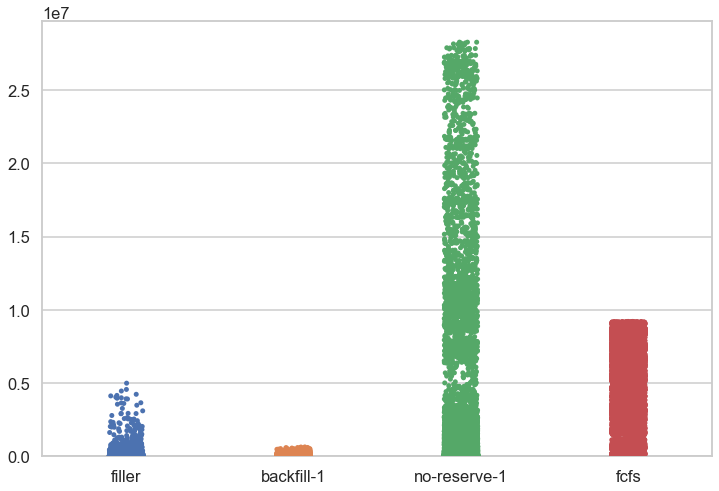

In [57]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=waiting_times, ax=ax)
ax.set_ylim(0)

(10805.203611948165, 10000000)

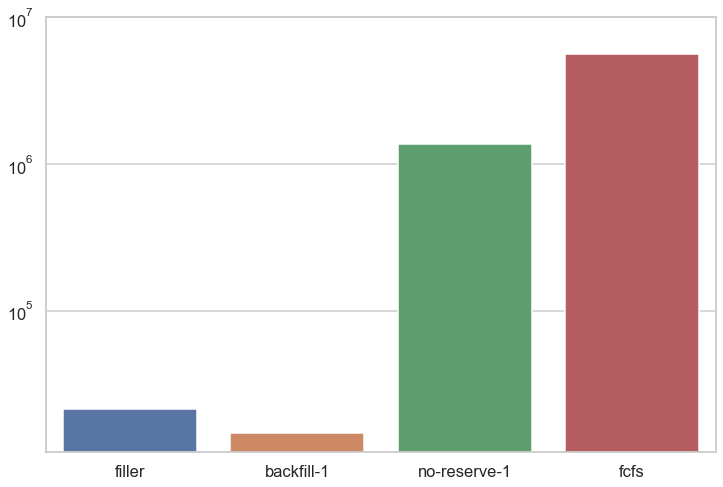

In [59]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=waiting_times, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**7)

(32125.68670948104, 10000000)

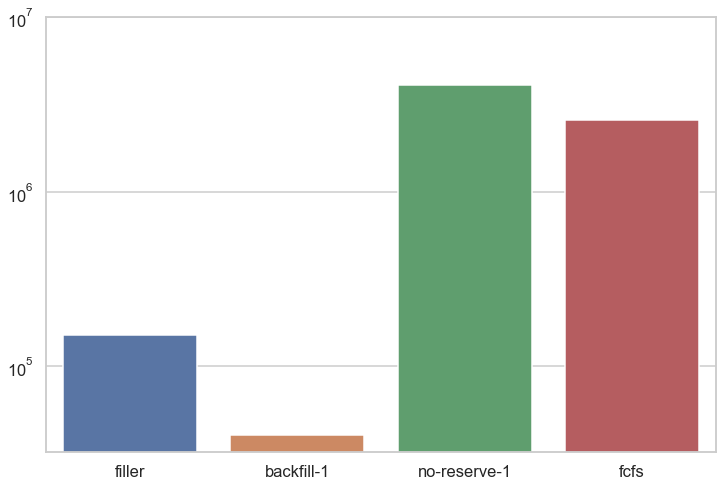

In [91]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=waiting_times, estimator=np.std, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**7)

(0.0, 1141854.9241616998)

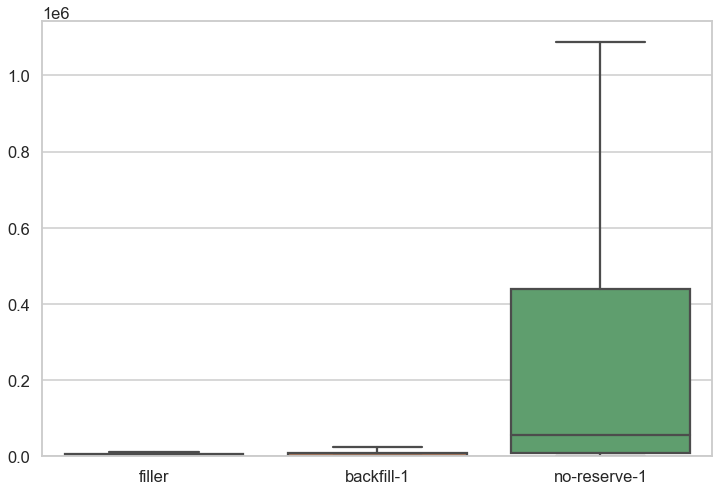

In [62]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=waiting_times.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

In [63]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,2.845300e+04,28453.000000,2.845300e+04,2.845300e+04
mean,3.004135e+04,23338.310470,1.374202e+06,5.632935e+06
std,1.523364e+05,47638.147605,4.084761e+06,2.598657e+06
min,9.040000e-02,0.166378,4.034460e-01,6.942760e-01
25%,1.690134e+02,228.354229,1.531496e+04,3.445598e+06
50%,5.318302e+03,6193.432889,6.488303e+04,6.213975e+06
75%,2.069844e+04,23883.842587,4.538184e+05,7.738259e+06
max,5.000808e+06,676610.196004,2.829267e+07,9.259564e+06


(0.0, 29707301.885630503)

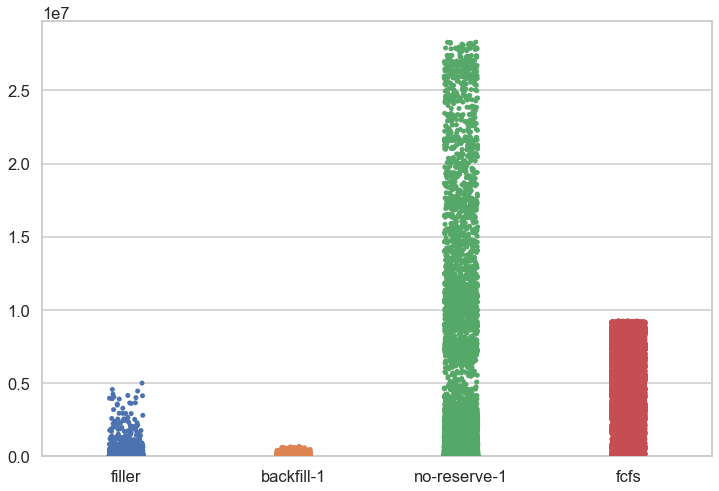

In [64]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=turnaround_times, ax=ax)
ax.set_ylim(0)

(17739.286403439037, 10000000)

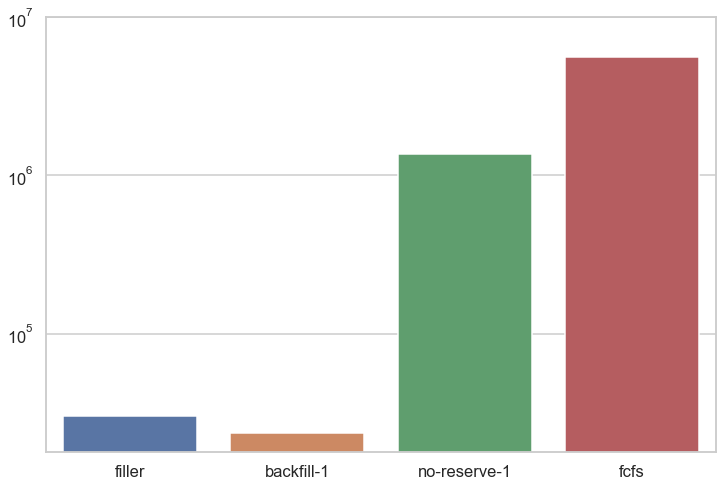

In [66]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=turnaround_times, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**7)

(38131.741817495706, 10000000)

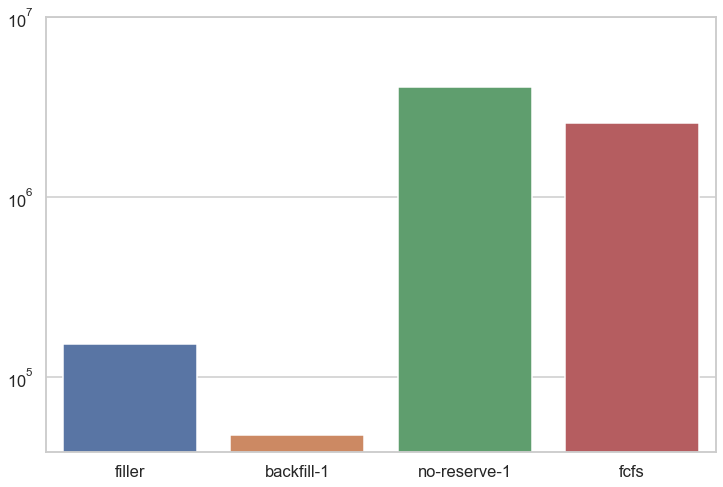

In [93]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=turnaround_times, estimator=np.std, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**7)

(0.0, 1167099.2155790483)

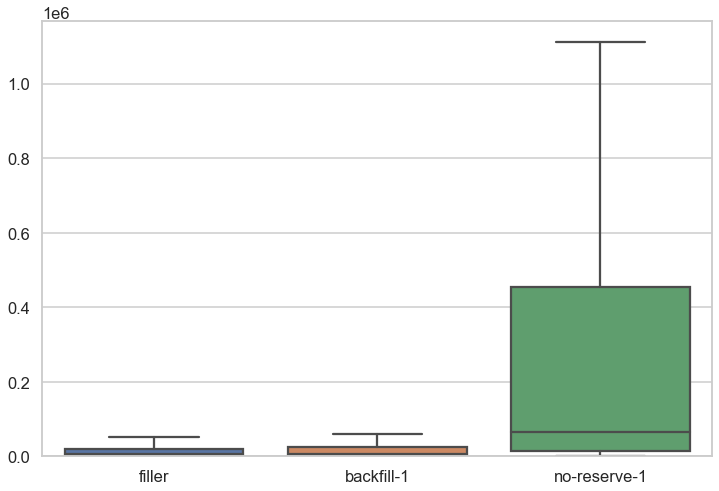

In [67]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=turnaround_times.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

In [68]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,no-reserve-1,fcfs
count,28453.000000,28453.000000,2.845300e+04,2.845300e+04
mean,180.639638,177.151205,1.344958e+04,1.482073e+05
std,1026.405021,1101.823154,6.965194e+04,6.297237e+05
min,1.000000,1.000000,1.000000e+00,1.000000e+00
25%,1.000000,1.000000,4.230993e+00,5.876836e+02
50%,1.000000,1.044776,1.205330e+02,6.306043e+03
75%,5.232060,7.975179,2.735765e+03,1.001881e+05
max,42459.521527,83237.330498,3.045390e+06,6.833794e+07


(0.0, 71754836.29956308)

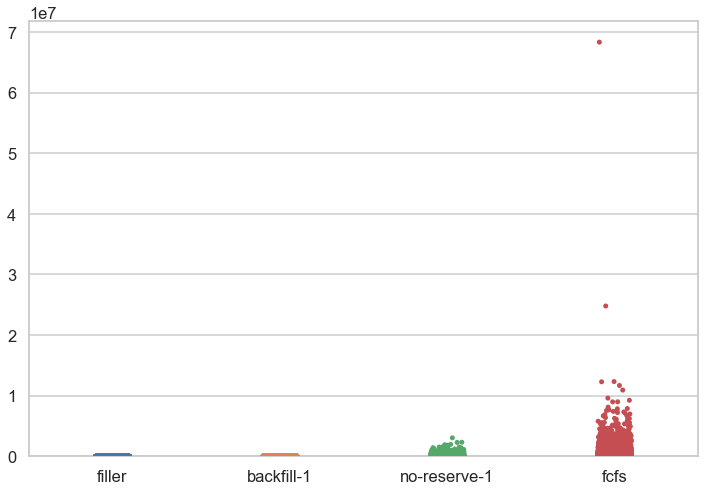

In [71]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(data=slowdown, ax=ax)
ax.set_ylim(0)

(126.5370883918993, 1000000)

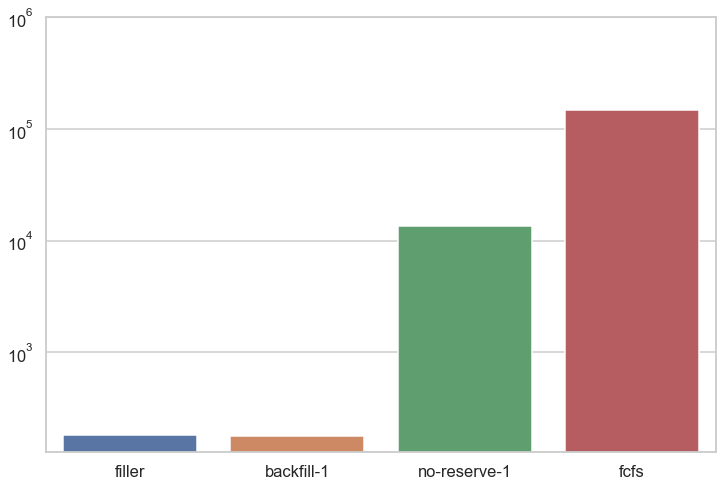

In [73]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=slowdown, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**6)

(744.5940678845571, 1000000)

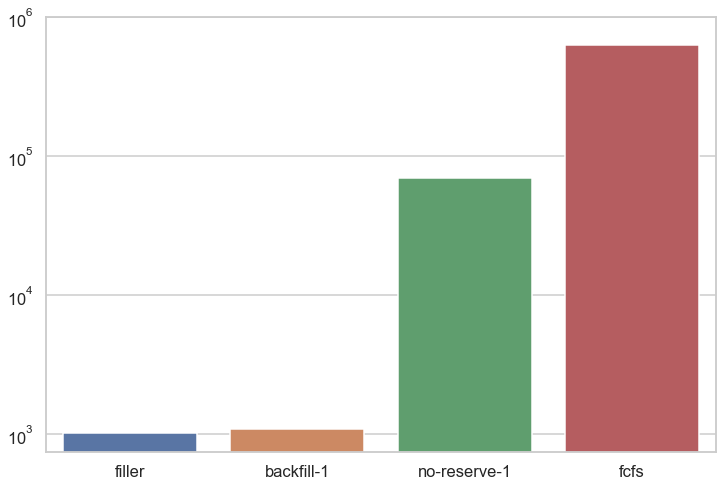

In [87]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=slowdown, estimator=np.std, ci=None, ax=ax)
ax.set_yscale('log')
ax.set_ylim(top=10**6)

(0.0, 7173.675808585842)

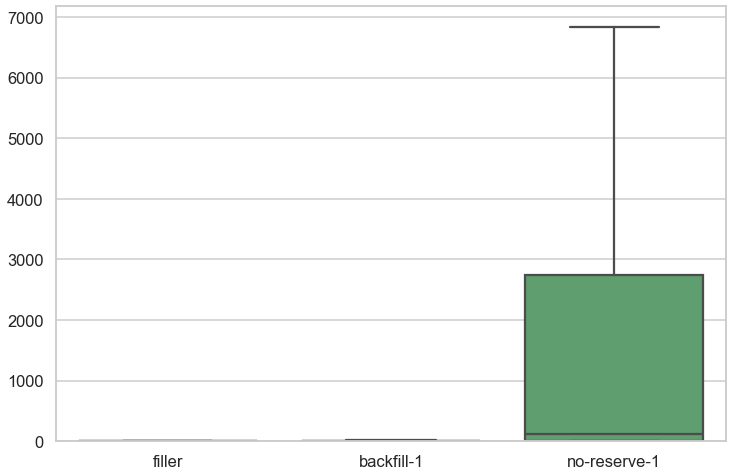

In [84]:
# Standard deviation
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=slowdown.drop(['fcfs'], axis=1), showfliers=False, ax=ax)
ax.set_ylim(0)

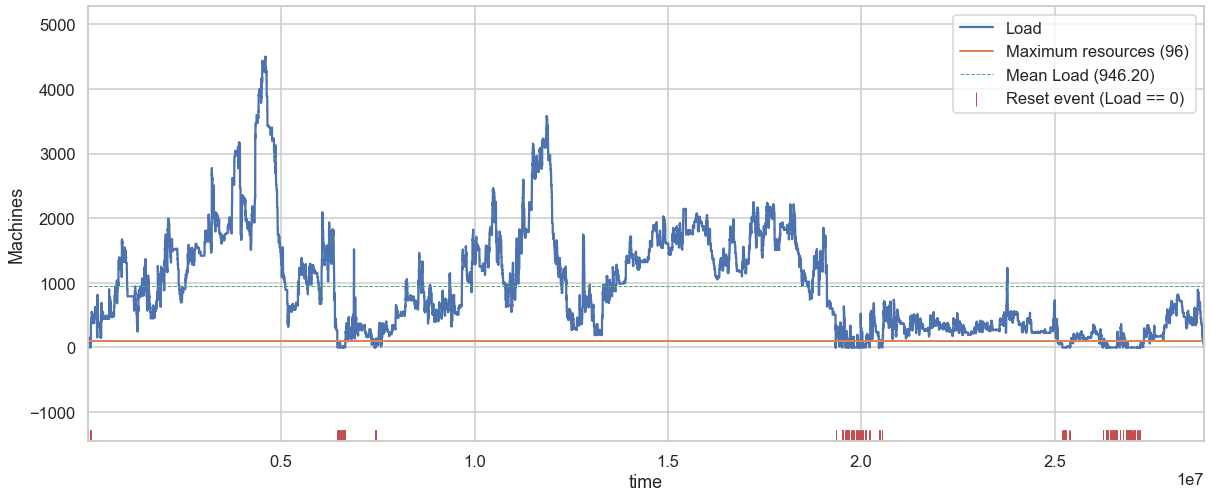

In [75]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)

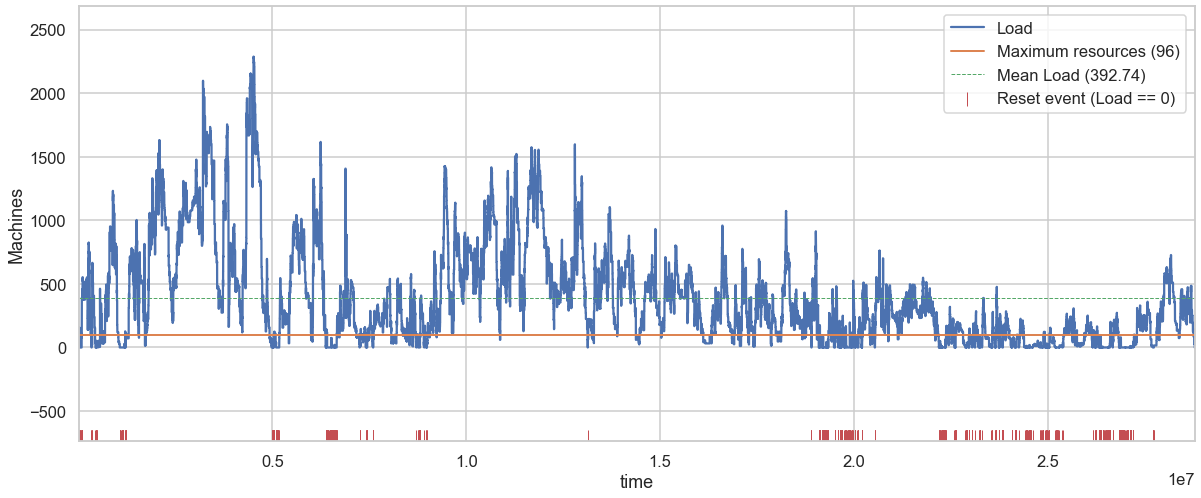

In [76]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

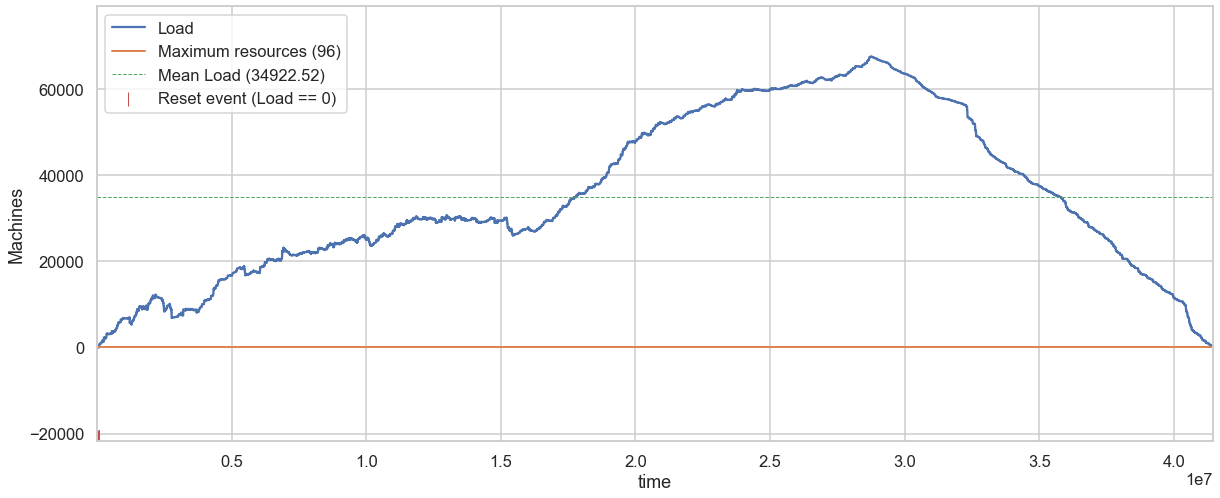

In [77]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['no-reserve-1'].queue, nb_resources=96, ax=ax)

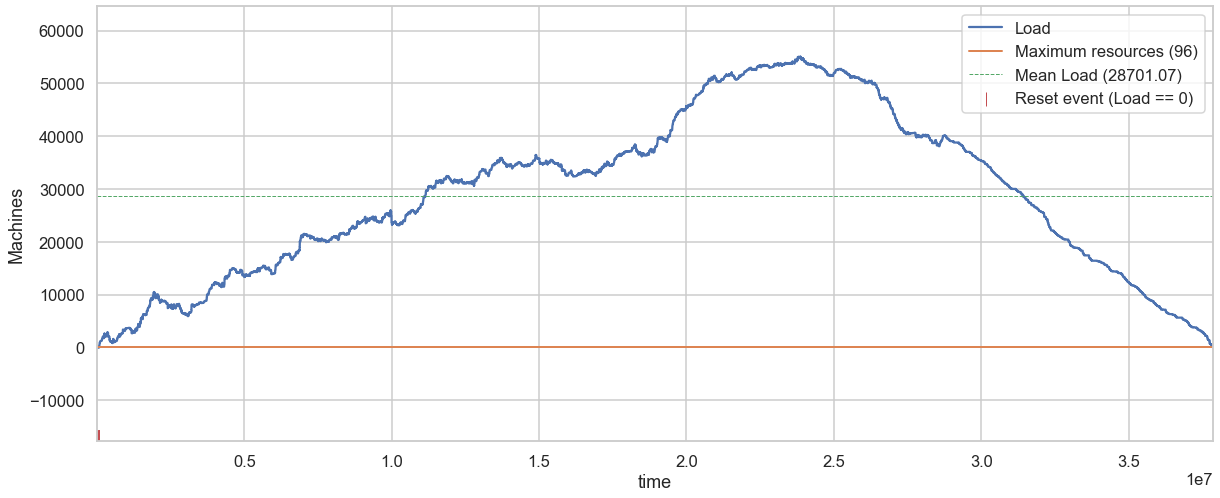

In [78]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)